## Using Featuretools to generate features to predict missed appointments

In this notebook, the [Featuretools](https://www.featuretools.com) was used to generate features relating to when patients did not show up to doctor's appointment. Once the features are generated, a Machine Learning model will be created to predict the "missed appointment", further the model will be evaluate and improve based on the evaluation metric

<hr style="border:1px solid black"> </hr>

# Contents:
<a href="#c1">1. Chapter 1: Data Wrangling and Exploration</a>

<a href="#c2">2. Chapter 2: Building features using Feature Tools</a>

<a href="#c3">3. Chapter 3: Model Selection</a>

<a href="#c4">4. Chapter 4: Build the Model and Evaluating the Model</a>

<hr style="border:1px solid black"> </hr>

# <a id="c1">1. Data Wrangling and Exploration</a>

In [1]:
# Import necessary libraries
import glob
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read all csv files

data = glob.glob("*.csv")
data

['KaggleV2-May-2016.csv']

In [3]:
# Importing the appt and change some data type

appt = pd.read_csv(data[0], parse_dates=['AppointmentDay', 'ScheduledDay'])
appt.index = appt['AppointmentID']
appt.rename(columns={'Hipertension': 'Hypertension',
                     'Scholarship': 'Financial_Assistance',
                     'Handcap': 'Handicap',
                     'PatientId': 'patient_id',
                     'AppointmentID': 'appointment_id',
                     'ScheduledDay': 'scheduled_time',
                     'AppointmentDay': 'appointment_day',
                     'No-show': 'No_show'}, inplace=True)

# Format the time of the appointment date to show until the end of the day instead
appt['appointment_day'] = appt['appointment_day'] + pd.Timedelta('1d') - pd.Timedelta('1s')

appt["Neighbourhood"] = appt["Neighbourhood"].astype('category') # Change the category data type

# Assign the respective columns as boolean type
for bool_col in ["Financial_Assistance", "Hypertension", "Diabetes", "Alcoholism", "Handicap", "SMS_received"]:
    appt[bool_col] = appt[bool_col].astype(bool)

appt['No_show'] = appt['No_show'].map({'No': False, 'Yes': True}) # Change the naming to less confusion value


appt

,patient_id,appointment_id,Gender,scheduled_time,appointment_day,Age,Neighbourhood,Financial_Assistance,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show
AppointmentID,,,,,,,,,,,,,,
5642903,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 23:59:59+00:00,62,JARDIM DA PENHA,False,True,False,False,False,False,False
5642503,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 23:59:59+00:00,56,JARDIM DA PENHA,False,False,False,False,False,False,False
5642549,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 23:59:59+00:00,62,MATA DA PRAIA,False,False,False,False,False,False,False
5642828,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 23:59:59+00:00,8,PONTAL DE CAMBURI,False,False,False,False,False,False,False
5642494,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 23:59:59+00:00,56,JARDIM DA PENHA,False,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5651768,2.572134e+12,5651768,F,2016-05-03 09:15:35+00:00,2016-06-07 23:59:59+00:00,56,MARIA ORTIZ,False,False,False,False,False,True,False
5650093,3.596266e+12,5650093,F,2016-05-03 07:27:33+00:00,2016-06-07 23:59:59+00:00,51,MARIA ORTIZ,False,False,False,False,False,True,False
5630692,1.557663e+13,5630692,F,2016-04-27 16:03:52+00:00,2016-06-07 23:59:59+00:00,21,MARIA ORTIZ,False,False,False,False,False,True,False


In [4]:
# Remove the timezone datetime
appt['scheduled_time'] = appt['scheduled_time'].dt.tz_convert(None)
appt['appointment_day'] = appt['appointment_day'].dt.tz_convert(None)
appt

,patient_id,appointment_id,Gender,scheduled_time,appointment_day,Age,Neighbourhood,Financial_Assistance,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show
AppointmentID,,,,,,,,,,,,,,
5642903,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29 23:59:59,62,JARDIM DA PENHA,False,True,False,False,False,False,False
5642503,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29 23:59:59,56,JARDIM DA PENHA,False,False,False,False,False,False,False
5642549,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29 23:59:59,62,MATA DA PRAIA,False,False,False,False,False,False,False
5642828,8.679512e+11,5642828,F,2016-04-29 17:29:31,2016-04-29 23:59:59,8,PONTAL DE CAMBURI,False,False,False,False,False,False,False
5642494,8.841186e+12,5642494,F,2016-04-29 16:07:23,2016-04-29 23:59:59,56,JARDIM DA PENHA,False,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5651768,2.572134e+12,5651768,F,2016-05-03 09:15:35,2016-06-07 23:59:59,56,MARIA ORTIZ,False,False,False,False,False,True,False
5650093,3.596266e+12,5650093,F,2016-05-03 07:27:33,2016-06-07 23:59:59,51,MARIA ORTIZ,False,False,False,False,False,True,False
5630692,1.557663e+13,5630692,F,2016-04-27 16:03:52,2016-06-07 23:59:59,21,MARIA ORTIZ,False,False,False,False,False,True,False


In [5]:
appt.describe()

,patient_id,appointment_id,Age
count,1.105270e+05,1.105270e+05,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874
std,2.560949e+14,7.129575e+04,23.110205
min,3.921784e+04,5.030230e+06,-1.000000
25%,4.172614e+12,5.640286e+06,18.000000
50%,3.173184e+13,5.680573e+06,37.000000
75%,9.439172e+13,5.725524e+06,55.000000
max,9.999816e+14,5.790484e+06,115.000000


In [6]:
# Based on the summary describe for the dataframe, there is an error in the age column
# As the lowest number for the age is -1, which is not valid therefore any rows that have age at "-1" will be removed
appt.drop(appt[appt.Age < 0].index, inplace=True)

appt

,patient_id,appointment_id,Gender,scheduled_time,appointment_day,Age,Neighbourhood,Financial_Assistance,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show
AppointmentID,,,,,,,,,,,,,,
5642903,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29 23:59:59,62,JARDIM DA PENHA,False,True,False,False,False,False,False
5642503,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29 23:59:59,56,JARDIM DA PENHA,False,False,False,False,False,False,False
5642549,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29 23:59:59,62,MATA DA PRAIA,False,False,False,False,False,False,False
5642828,8.679512e+11,5642828,F,2016-04-29 17:29:31,2016-04-29 23:59:59,8,PONTAL DE CAMBURI,False,False,False,False,False,False,False
5642494,8.841186e+12,5642494,F,2016-04-29 16:07:23,2016-04-29 23:59:59,56,JARDIM DA PENHA,False,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5651768,2.572134e+12,5651768,F,2016-05-03 09:15:35,2016-06-07 23:59:59,56,MARIA ORTIZ,False,False,False,False,False,True,False
5650093,3.596266e+12,5650093,F,2016-05-03 07:27:33,2016-06-07 23:59:59,51,MARIA ORTIZ,False,False,False,False,False,True,False
5630692,1.557663e+13,5630692,F,2016-04-27 16:03:52,2016-06-07 23:59:59,21,MARIA ORTIZ,False,False,False,False,False,True,False


(array([    0.,  2500.,  5000.,  7500., 10000., 12500., 15000., 17500.,
        20000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

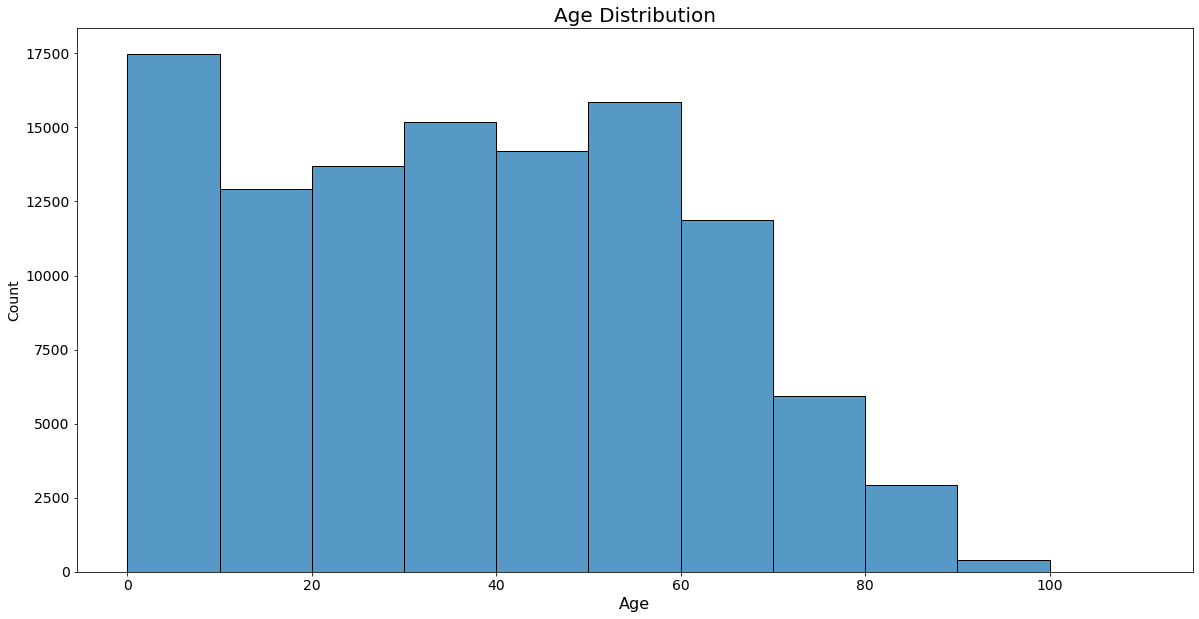

In [141]:
# Plot graph to show the age distribution

plt.figure(figsize=(20,10))
sns.histplot(x='Age', data=appt, bins=range(0,115,10))
plt.title("Age Distribution", size=20)
plt.xlabel('Age',size=16)
plt.ylabel("Count", size=14)
plt.xticks(size=14)
plt.yticks(size=14)

In [37]:
scholar_appnt = appt.groupby('Financial_Assistance')['No_show'].value_counts().to_frame('Count').reset_index()
scholar_appnt

,Financial_Assistance,No_show,Count
0,False,False,79924
1,False,True,19741
2,True,False,8283
3,True,True,2578


<AxesSubplot:xlabel='Financial_Assistance', ylabel='Count'>

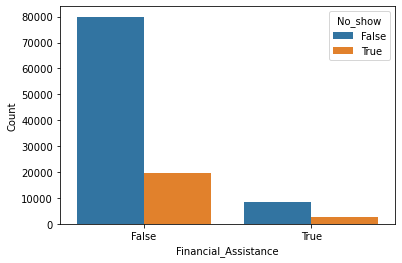

In [39]:
sns.barplot(x='Financial_Assistance', y='Count', hue='No_show', data=scholar_appnt)

In [132]:
age_financial = appt[['patient_id', 'Age', 'Financial_Assistance', 'No_show']]
age_fin_noshow = age_financial.loc[age_financial['No_show']]
age_fin_showup = age_financial.loc[~age_financial['No_show']]
age_financial

,patient_id,Age,Financial_Assistance,No_show
AppointmentID,,,,
5642903,2.987250e+13,62,False,False
5642503,5.589978e+14,56,False,False
5642549,4.262962e+12,62,False,False
5642828,8.679512e+11,8,False,False
5642494,8.841186e+12,56,False,False
...,...,...,...,...
5651768,2.572134e+12,56,False,False
5650093,3.596266e+12,51,False,False
5630692,1.557663e+13,21,False,False


In [129]:
age_fin_noshow

,patient_id,Age,Financial_Assistance,No_show
AppointmentID,,,,
5630279,7.336882e+14,23,False,True
5630575,3.449833e+12,39,False,True
5620163,7.542951e+12,29,False,True
5633460,1.479497e+13,40,True,True
5626083,6.222575e+14,30,False,True
...,...,...,...,...
5772155,5.133650e+14,45,False,True
5786741,6.456342e+14,33,False,True
5779046,8.544295e+13,37,False,True


<AxesSubplot:xlabel='Age', ylabel='Count'>

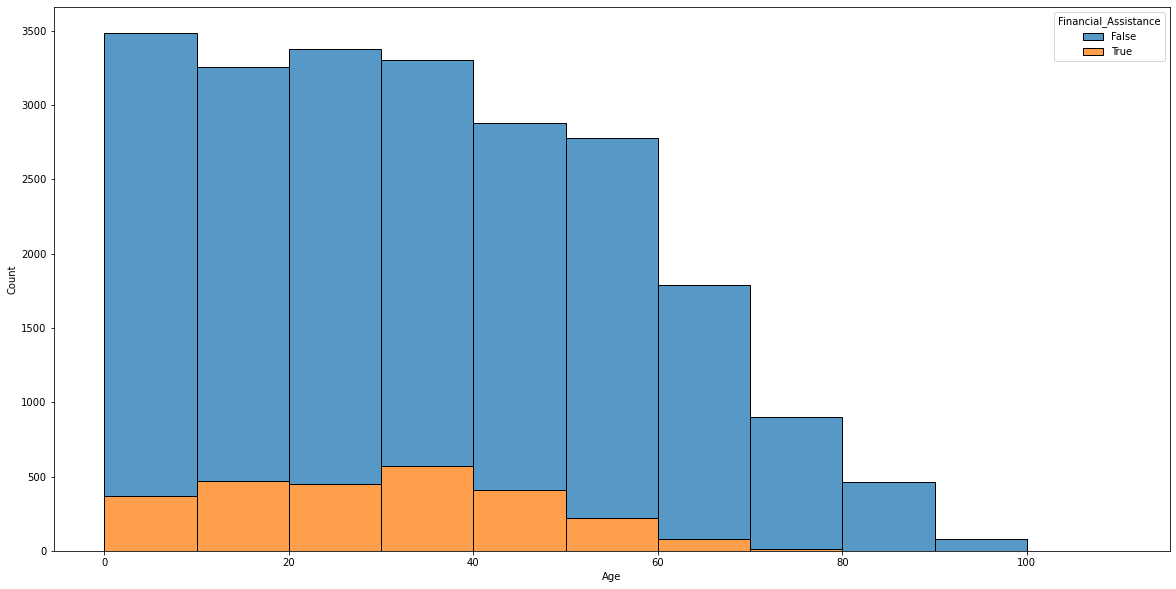

In [142]:
plt.figure(figsize=(20,10))
sns.histplot(x='Age', hue='Financial_Assistance', data=age_fin_noshow,multiple='stack',
            bins=range(0,115,10))

<AxesSubplot:xlabel='Age', ylabel='Count'>

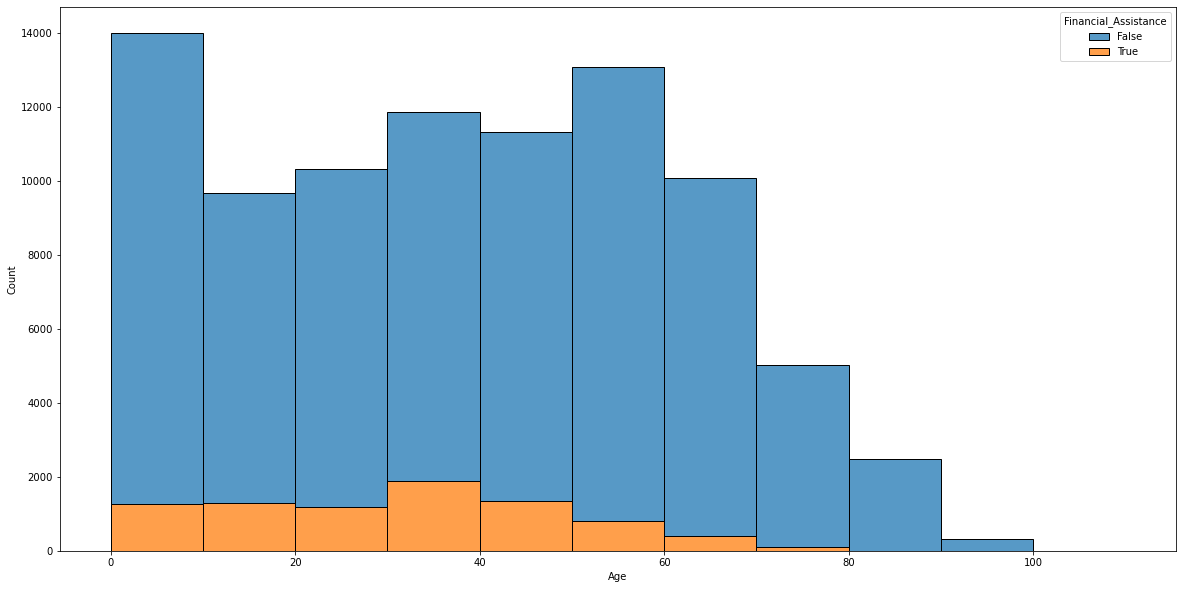

In [143]:
plt.figure(figsize=(20,10))
sns.histplot(x='Age', hue='Financial_Assistance', data=age_fin_showup,multiple='stack',
            bins=range(0,115,10))

<AxesSubplot:xlabel='Age', ylabel='Count'>

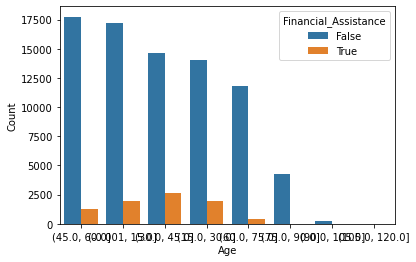

In [61]:
sns.barplot(x='Age', y='Count', hue='Financial_Assistance', data=age_fin_show)

In [42]:
"""
Counting the number of patients that show up to the appointment and their respected gender and scholarship
and subsequently seprated the data that is False or True in no_show column
"""

gender_scholar = appt.groupby(['Gender', 'Financial_Assistance'])[
    'No_show'].value_counts().to_frame('Count').reset_index()
gender_scholar_noshw = gender_scholar.loc[gender_scholar['No_show']]
gender_scholar_show = gender_scholar.loc[~gender_scholar['No_show']]

In [44]:
gender_scholar_noshw

,Gender,Financial_Assistance,No_show,Count
1,F,False,True,12488
3,F,True,True,2106
5,M,False,True,7253
7,M,True,True,472


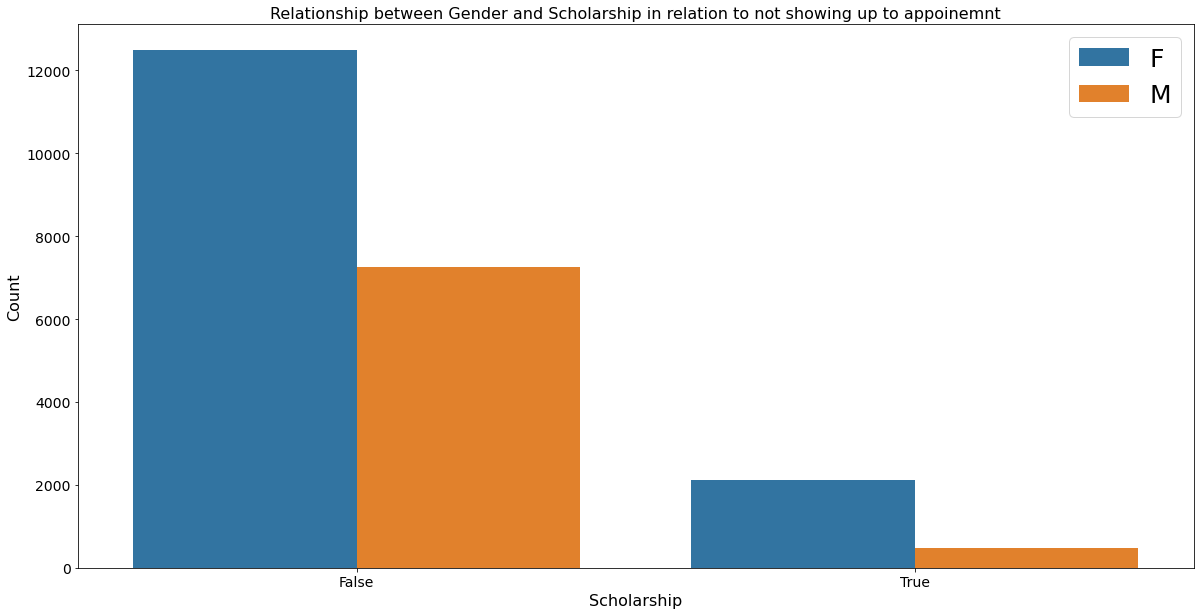

In [28]:
plt.figure(figsize=(20,10))
sns.barplot(x='Scholarship', y='Count', hue='Gender', data=gender_scholar_noshw)
plt.title("Relationship between Gender and Financial Assistance in relation to not showing up to appoinemnt", size = 16)
plt.xlabel('Scholarship', size=16)
plt.ylabel('Count', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=25)

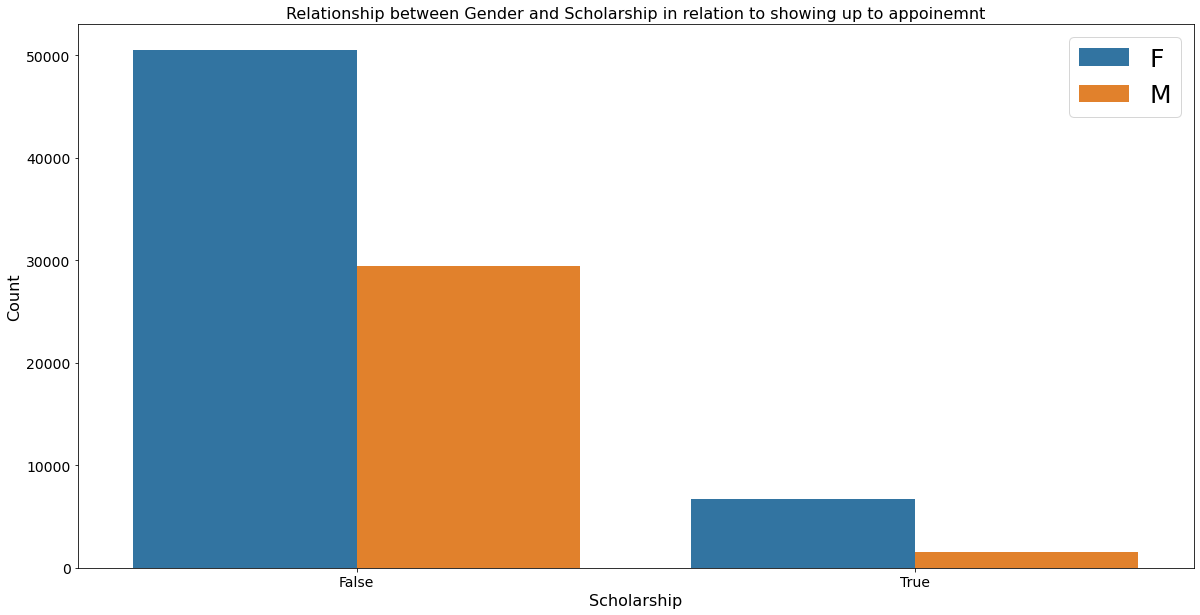

In [29]:
plt.figure(figsize=(20,10))
sns.barplot(x='Scholarship', y='Count', hue='Gender', data=gender_scholar_show)
plt.title("Relationship between Gender and Scholarship in relation to showing up to appoinemnt", size = 16)
plt.xlabel('Scholarship', size=16)
plt.ylabel('Count', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=25)

In [70]:
gender_hypertension = appt.groupby(['Gender', 'Hypertension'])['No_show'].value_counts().to_frame('Count').reset_index()
gender_hypertension_noshw = gender_hypertension.loc[gender_hypertension['No_show']]
gender_hypertension_show = gender_hypertension.loc[~gender_hypertension['No_show']]
gender_hypertension

,Gender,Hypertension,No_show,Count
0,F,False,False,44563
1,F,False,True,11937
2,F,True,False,12682
3,F,True,True,2657
4,M,False,False,25615
5,M,False,True,6610
6,M,True,False,5347
7,M,True,True,1115


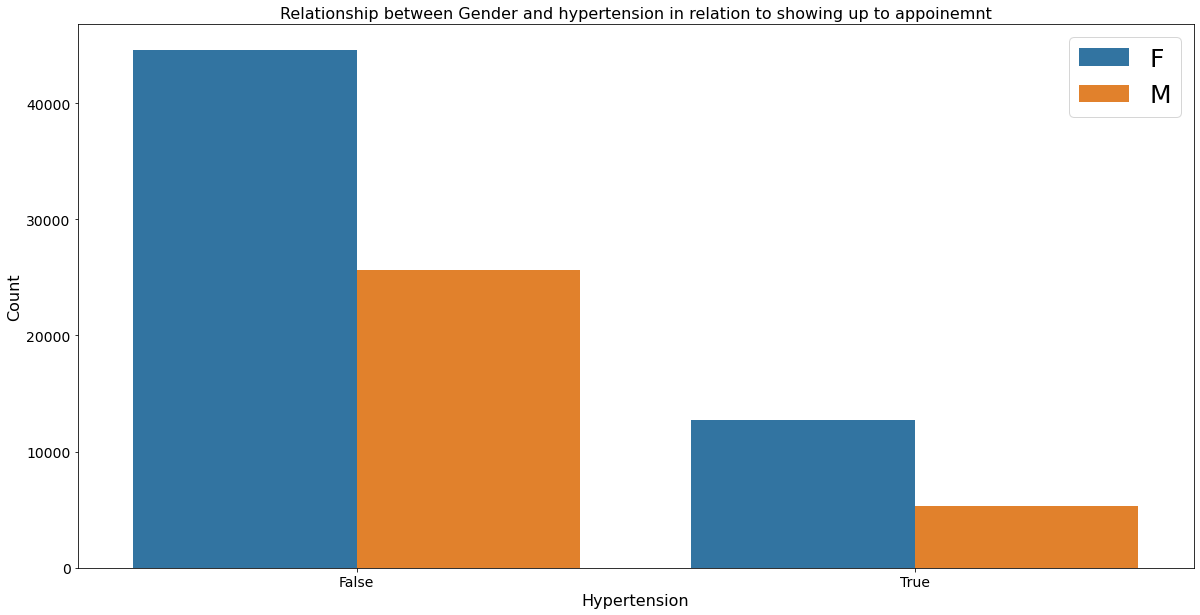

In [72]:
plt.figure(figsize=(20,10))
sns.barplot(x='Hypertension', y='Count', hue='Gender', data=gender_hypertension_show)
plt.title("Relationship between Gender and hypertension in relation to showing up to appoinemnt", size = 16)
plt.xlabel('Hypertension', size=16)
plt.ylabel('Count', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=25)

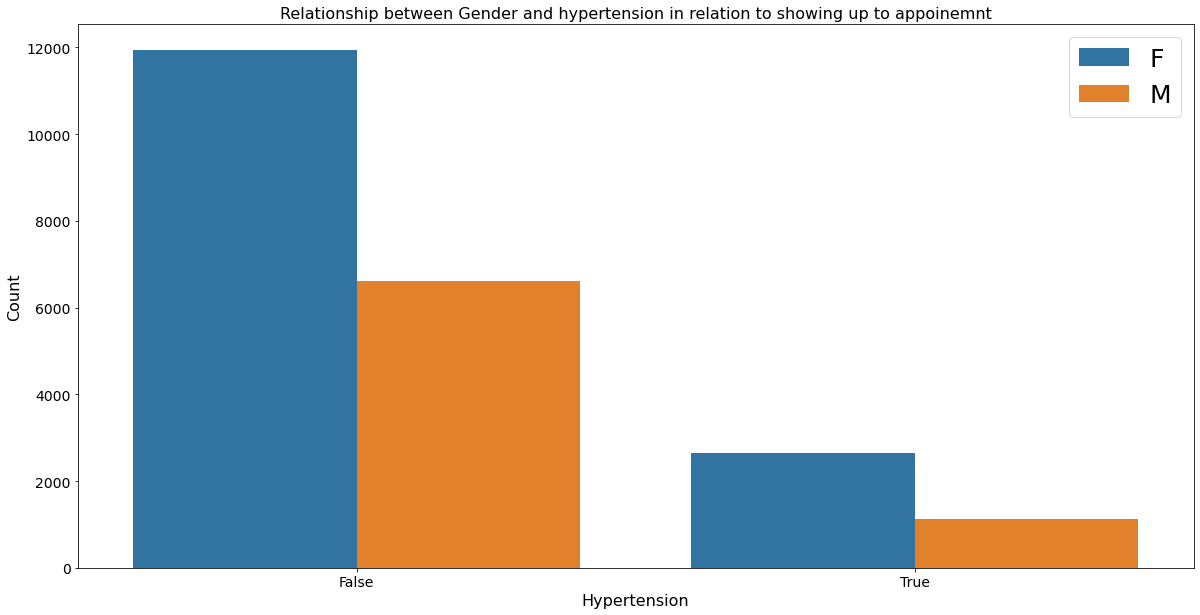

In [73]:
plt.figure(figsize=(20,10))
sns.barplot(x='Hypertension', y='Count', hue='Gender', data=gender_hypertension_noshw)
plt.title("Relationship between Gender and hypertension in relation to showing up to appoinemnt", size = 16)
plt.xlabel('Hypertension', size=16)
plt.ylabel('Count', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=25)

In [76]:
gender_diabetes = appt.groupby(['Gender', 'Diabetes'])['No_show'].value_counts().to_frame('Count').reset_index()
gender_diabetes_noshw = gender_diabetes.loc[gender_diabetes['No_show']]
gender_diabetes_show = gender_diabetes.loc[~gender_diabetes['No_show']]
gender_diabetes

,Gender,Diabetes,No_show,Count
0,F,False,False,52656
1,F,False,True,13577
2,F,True,False,4589
3,F,True,True,1017
4,M,False,False,29038
5,M,False,True,7312
6,M,True,False,1924
7,M,True,True,413


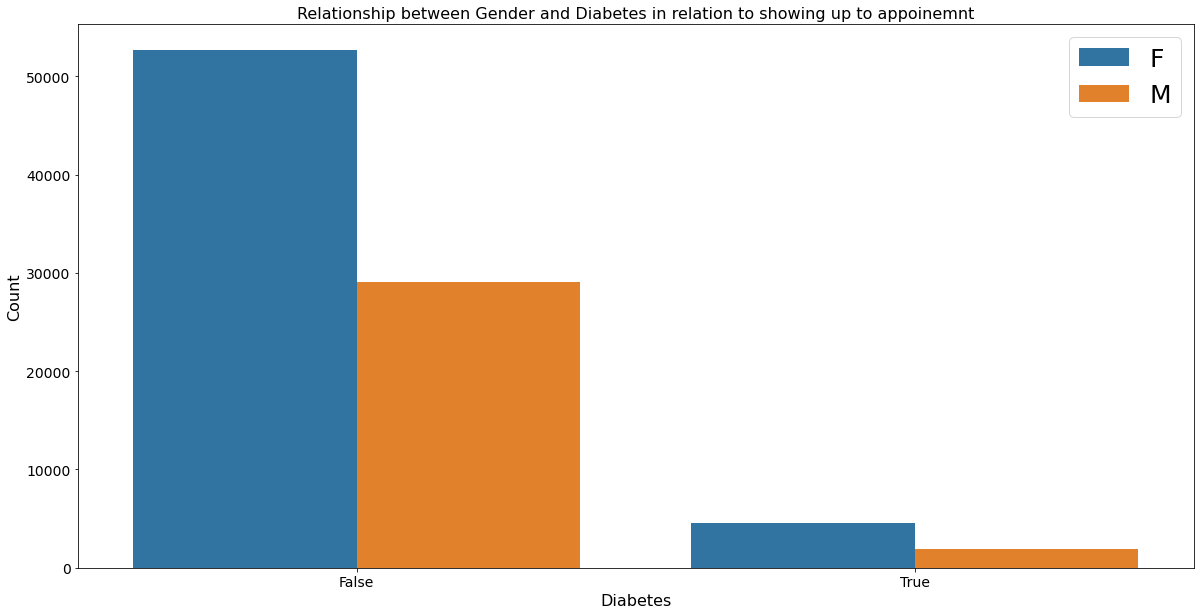

In [78]:
plt.figure(figsize=(20,10))
sns.barplot(x='Diabetes', y='Count', hue='Gender', data=gender_diabetes_show)
plt.title("Relationship between Gender and Diabetes in relation to showing up to appoinemnt", size = 16)
plt.xlabel('Diabetes', size=16)
plt.ylabel('Count', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=25)

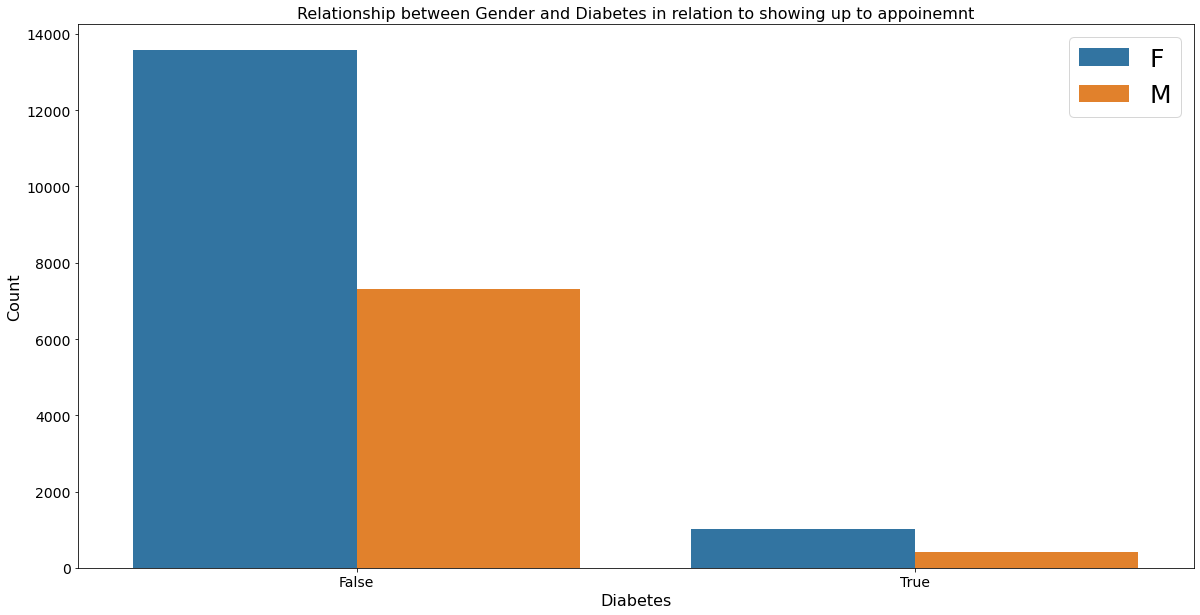

In [80]:
plt.figure(figsize=(20,10))
sns.barplot(x='Diabetes', y='Count', hue='Gender', data=gender_diabetes_noshw)
plt.title("Relationship between Gender and Diabetes in relation to showing up to appoinemnt", size = 16)
plt.xlabel('Diabetes', size=16)
plt.ylabel('Count', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=25)

In [81]:
gender_alcoholism = appt.groupby(['Gender', 'Alcoholism'])['No_show'].value_counts().to_frame('Count').reset_index()
gender_alcoholism_noshw = gender_alcoholism.loc[gender_alcoholism['No_show']]
gender_alcoholism_show = gender_alcoholism.loc[~gender_alcoholism['No_show']]
gender_alcoholism

,Gender,Alcoholism,No_show,Count
0,F,False,False,56330
1,F,False,True,14286
2,F,True,False,915
3,F,True,True,308
4,M,False,False,29194
5,M,False,True,7356
6,M,True,False,1768
7,M,True,True,369


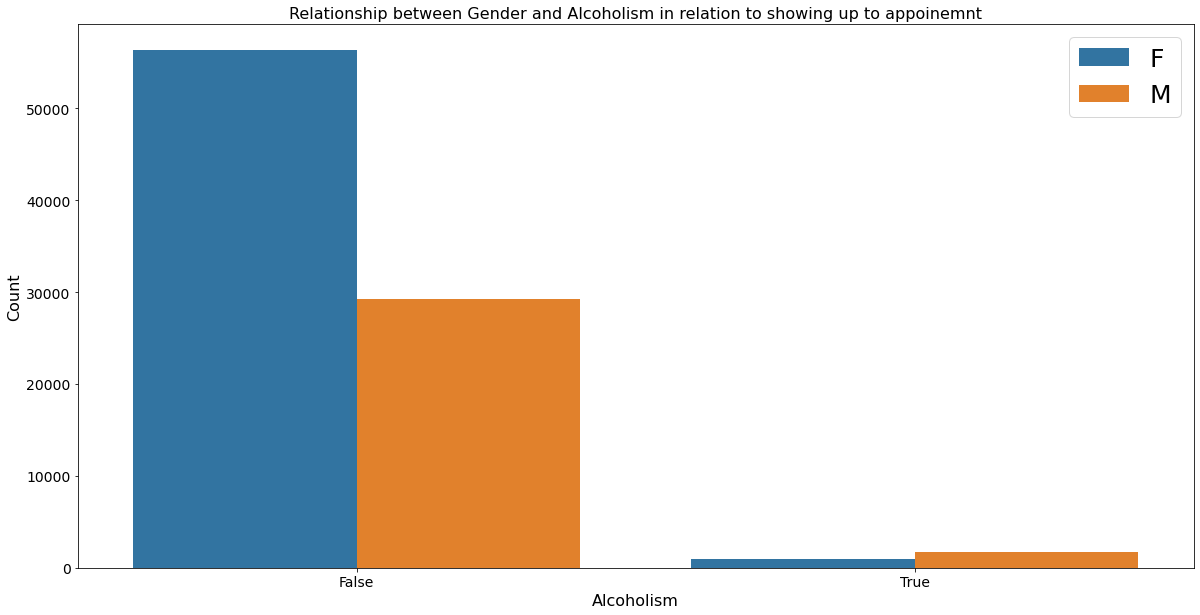

In [82]:
plt.figure(figsize=(20,10))
sns.barplot(x='Alcoholism', y='Count', hue='Gender', data=gender_alcoholism_show)
plt.title("Relationship between Gender and Alcoholism in relation to showing up to appoinemnt", size = 16)
plt.xlabel('Alcoholism', size=16)
plt.ylabel('Count', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=25)

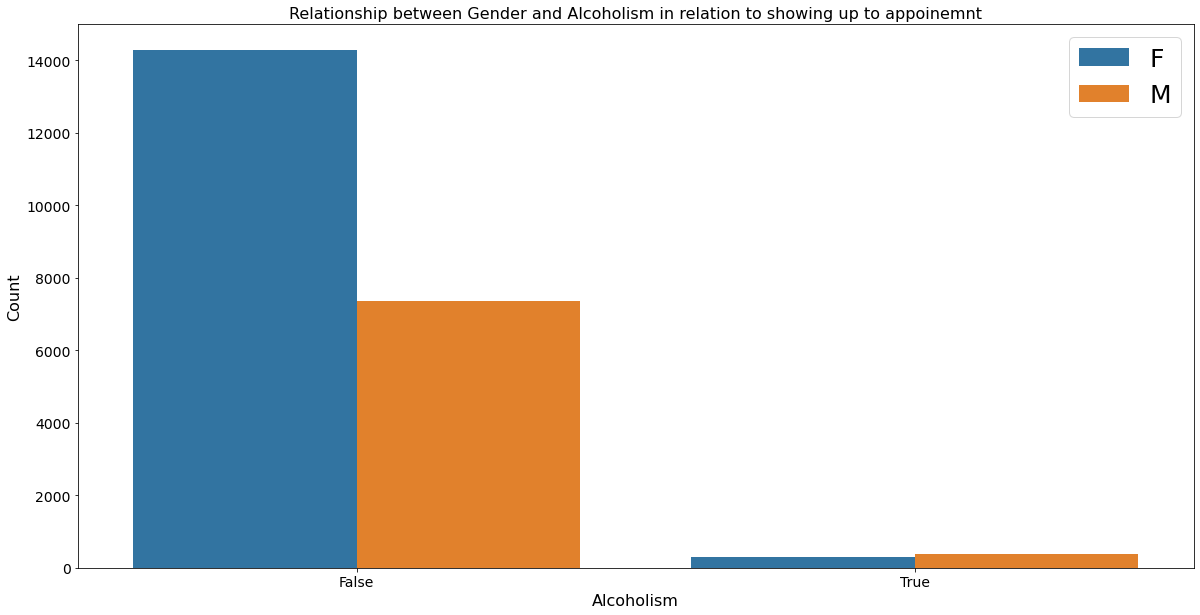

In [84]:
plt.figure(figsize=(20,10))
sns.barplot(x='Alcoholism', y='Count', hue='Gender', data=gender_alcoholism_noshw)
plt.title("Relationship between Gender and Alcoholism in relation to showing up to appoinemnt", size = 16)
plt.xlabel('Alcoholism', size=16)
plt.ylabel('Count', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=25)

In [86]:
gender_handicap = appt.groupby(['Gender', 'Handicap'])['No_show'].value_counts().to_frame('Count').reset_index()
gender_handicap_noshw = gender_handicap.loc[gender_handicap['No_show']]
gender_handicap_show = gender_handicap.loc[~gender_handicap['No_show']]
gender_handicap

,Gender,Handicap,No_show,Count
0,F,False,False,56198
1,F,False,True,14351
2,F,True,False,1047
3,F,True,True,243
4,M,False,False,30175
5,M,False,True,7561
6,M,True,False,787
7,M,True,True,164


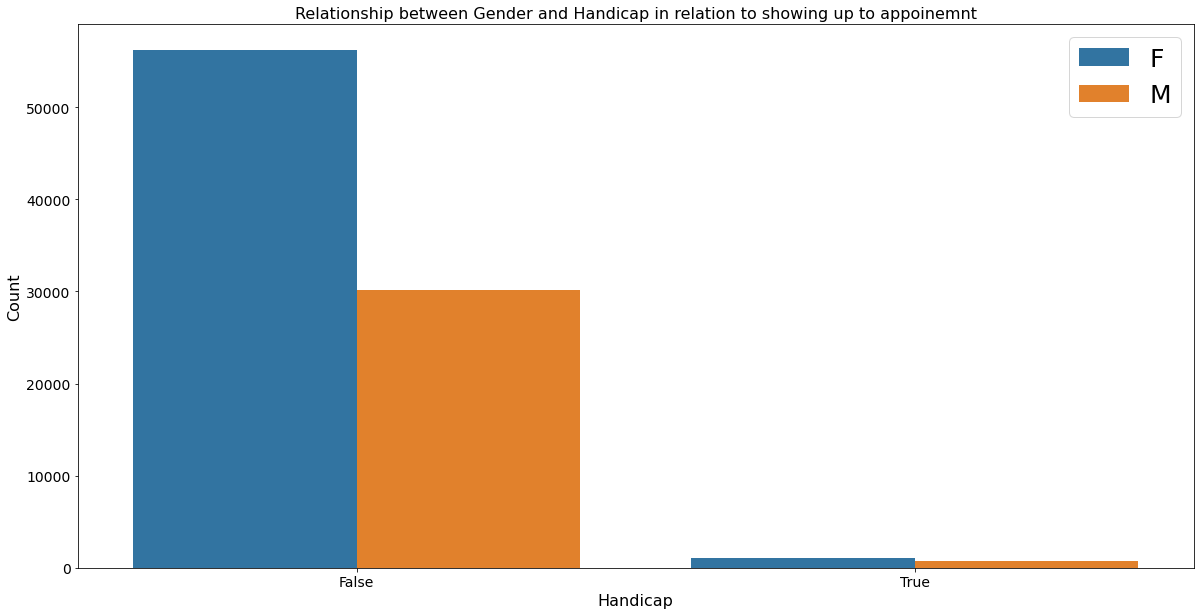

In [87]:
plt.figure(figsize=(20,10))
sns.barplot(x='Handicap', y='Count', hue='Gender', data=gender_handicap_show)
plt.title("Relationship between Gender and Handicap in relation to showing up to appoinemnt", size = 16)
plt.xlabel('Handicap', size=16)
plt.ylabel('Count', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=25)

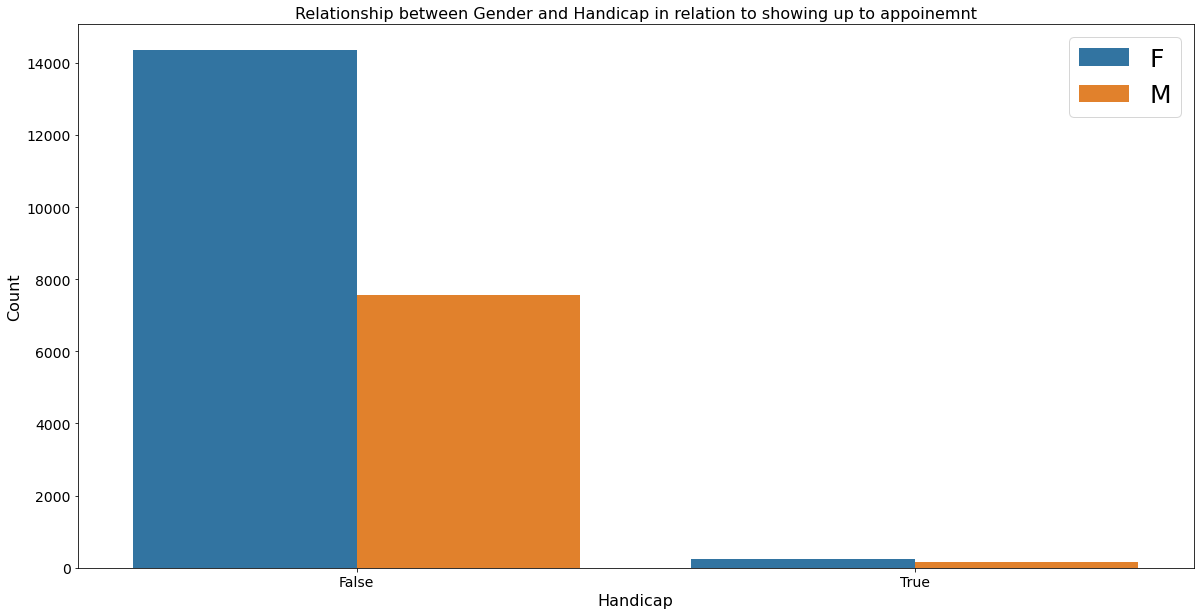

In [88]:
plt.figure(figsize=(20,10))
sns.barplot(x='Handicap', y='Count', hue='Gender', data=gender_handicap_noshw)
plt.title("Relationship between Gender and Handicap in relation to showing up to appoinemnt", size = 16)
plt.xlabel('Handicap', size=16)
plt.ylabel('Count', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=25)

## After exploring, it seems in majority that the Female group tend to show up to the doctor's appoinment and at the same time they are also tend to not shwing up to the doctor's appointment as evidently shown fem.

## The one scenario that the male dominate over the female is when the patient is "True" in alcoholism both not showing up and show up to the appointment.

In [68]:
gender_SMS = appt.groupby(['Gender', 'SMS_received'])['No_show'].value_counts().to_frame('Count').reset_index()
gender_SMS_noshw = gender_SMS.loc[gender_SMS['No_show']]
gender_SMS_show = gender_SMS.loc[~gender_SMS['No_show']]
gender_SMS

,Gender,SMS_received,No_show,Count
0,F,False,False,39763
1,F,False,True,7874
2,F,True,False,17482
3,F,True,True,6720
4,M,False,False,22746
5,M,False,True,4661
6,M,True,False,8216
7,M,True,True,3064


In [89]:
Appnt_show = appt['No_show'].value_counts(normalize=True).reset_index()
Appnt_show.columns = ['No_show', 'Count']
Appnt_show

,No_show,Count
0,False,0.798066
1,True,0.201934


<AxesSubplot:xlabel='No_show'>

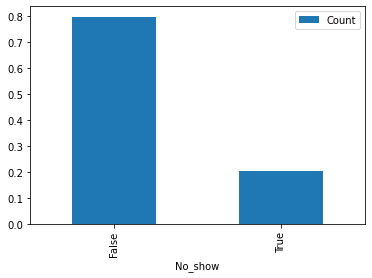

In [90]:
Appnt_show.plot.bar(x = 'No_show', y = 'Count')

In [ ]:
appt['Neighbourhood'].value_counts(normalize=True).reset_index()

In [ ]:
appt['Gender'].value_counts()

In [91]:
# Showing top 10 neighbourhoods with their according no-show records

neighbour_no_show = appt.groupby('Neighbourhood')['No_show'].value_counts().to_frame(name='Count').reset_index()
neighbour_no_show['percentage'] = (neighbour_no_show['Count']/neighbour_no_show['Count'].sum()) * 100
neighbour_no_show
# Sort out top and lowest 10 count from each neibourhoods and their according no-show record

# Top 10 neighbourhood count with no show
noshw_top_10=neighbour_no_show.sort_values(['No_show', 'Count'], ascending=[True, False]).iloc[:10,:]

# Bottom 10 neighbourhood count with no show record
noshw_bot_10=neighbour_no_show.sort_values(['No_show', 'Count'], ascending=[True, True]).iloc[:10,:]

# Top 10 neighbourhood count that shows up
show_top_10=neighbour_no_show.sort_values(['No_show', 'Count'], ascending=[False, False]).iloc[:10,:]

# Bottom 10 neighbourhood count that shows up
show_bot_10=neighbour_no_show.sort_values(['No_show', 'Count'], ascending=[False, True]).iloc[:10,:]


<AxesSubplot:xlabel='Neighbourhood'>

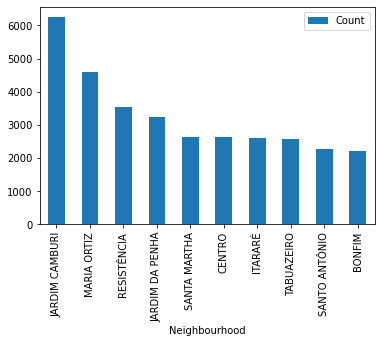

In [92]:
# Top 10 neighourhood count with no show record

noshw_top_10.plot.bar(x = 'Neighbourhood', y = 'Count')

In [ ]:
# Top 10 neighourhood count that shows up

show_top_10.plot.bar(x = 'Neighbourhood', y = 'Count')

In [ ]:
# Bottom 10 neighourhood count with no show record

noshw_bot_10.plot.bar(x = 'Neighbourhood', y = 'Count')

In [ ]:
# Bottom 10 neighourhood count that shows up

show_bot_10.plot.bar(x = 'Neighbourhood', y = 'Count')

In [ ]:
# Creating a bin for age
age_bin = [0,15,30,45,60,75,90,105,120]

# Getting a count for different age group
Age_show = appt.groupby('No_show')['Age'].value_counts(bins=age_bin).to_frame(name='Count').reset_index()
Age_show

In [ ]:
pd.cut(appt['Age'], bins=age_bin, include_lowest=True).groupby(appt['No-show']).value_counts()

<hr style="border:1px solid black"> </hr>

# <a id="c2">2. Using Feature Tools to generate features</a>

To generate new features (Feature Engineering) require us to understand the data to create numeric rows as an input for machine learning algorithms. With the assistant of featuretools, we do not need to do this by hand, simply we just need to 
pass into featuretools on what we know about the data and specify parameters for featuretools to then generate extra features based on the requirements.

Before starting to generate features from feature tools, the first step is to create an EntitySet. EntitySet primary function is to store information about entities (database tables), variables, relationship and the database itself, and entity in simsple term is a table or a dataframe as such each entity needs to have an index a unique identification for a column.

The time index and secondary time index notate what time the data is recorded. By doing that, we can avoid using data from the future while creating features. Since the label is in the dataframe, we either need to specify a time index or drop the column entirely.

Feature tools will attempt to interpret type of variables, this can be done manually to assign a specific types to a variable.

To be able to utilise the Deep Feature Synthesis (DFS) to its fullest it is better to do some data cleaning to remove data redundancy, by doing so the DFS can leverage the data to generate better features. To do this, a feature within EntitySet called normalize_entity is utilised to do this, the normalize_entity goal is to create a new entity and relationship from unique values of an existing variable.

To create a normalize_entity, first we need to specify where to start, then the name of the new entity and the last is the entity index.

Cutoff_time is one of the parameters within DFS, the main point of this parameter is to calculate the features for each training example at the specific time associate with that example. Reference: "https://www.kdnuggets.com/2018/02/deep-feature-synthesis-automated-feature-engineering.html"

In [7]:
# Import feature tools and relevant libraries
import featuretools as ft
from featuretools import variable_types as vtypes

In [14]:
appt

,patient_id,appointment_id,Gender,scheduled_time,appointment_day,Age,Neighbourhood,Financial_Assistance,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show
AppointmentID,,,,,,,,,,,,,,
5642903,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29 23:59:59,62,JARDIM DA PENHA,False,True,False,False,False,False,False
5642503,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29 23:59:59,56,JARDIM DA PENHA,False,False,False,False,False,False,False
5642549,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29 23:59:59,62,MATA DA PRAIA,False,False,False,False,False,False,False
5642828,8.679512e+11,5642828,F,2016-04-29 17:29:31,2016-04-29 23:59:59,8,PONTAL DE CAMBURI,False,False,False,False,False,False,False
5642494,8.841186e+12,5642494,F,2016-04-29 16:07:23,2016-04-29 23:59:59,56,JARDIM DA PENHA,False,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5651768,2.572134e+12,5651768,F,2016-05-03 09:15:35,2016-06-07 23:59:59,56,MARIA ORTIZ,False,False,False,False,False,True,False
5650093,3.596266e+12,5650093,F,2016-05-03 07:27:33,2016-06-07 23:59:59,51,MARIA ORTIZ,False,False,False,False,False,True,False
5630692,1.557663e+13,5630692,F,2016-04-27 16:03:52,2016-06-07 23:59:59,21,MARIA ORTIZ,False,False,False,False,False,True,False


In [15]:
# Assign specific type to a variable that we desire
variable_types = {'Gender': vtypes.Categorical,
                  'patient_id': vtypes.Categorical,
                  'Age': vtypes.Ordinal,
                  'Financial_Assistance': vtypes.Boolean,
                  'Hypertension': vtypes.Boolean,
                  'Diabetes': vtypes.Boolean,
                  'Alcoholism': vtypes.Boolean,
                  'Handicap': vtypes.Boolean,
                  'No_show': vtypes.Boolean,
                  'SMS_received': vtypes.Boolean}

# Creating an entity from dataframe

es = ft.EntitySet('Appointments')

es = es.entity_from_dataframe(entity_id='appointments',  # entity name
                              dataframe=appt,
                              index='appointment_id',
                              time_index='scheduled_time',
                              secondary_time_index={'appointment_day': ['No_show', 'SMS_received']},
                              variable_types=variable_types)


In [16]:
# Normalizing the entity
es.normalize_entity('appointments', 'patients', 'patient_id',
                    additional_variables=['Financial_Assistance',
                                          'Hypertension',
                                          'Diabetes',
                                          'Alcoholism',
                                          'Handicap'])

# Make locations, ages and genders
es.normalize_entity('appointments', 'locations', 'Neighbourhood',
                    make_time_index=False)
es.normalize_entity('appointments', 'ages', 'Age',
                    make_time_index=False)
es.normalize_entity('appointments', 'genders', 'Gender',
                    make_time_index=False)

# Take the index and the appointment time to use as a cutoff time
cutoff_times = es['appointments'].df[['appointment_id', 'scheduled_time', 'No_show']].sort_values(by='scheduled_time')

# Rename columns to avoid confusion
cutoff_times.rename(columns = {'scheduled_time': 'time', 
                               'No_show': 'label'},
                    inplace = True)

Primitives are building blocks in DFS, primitives represent calcuations that can be stack on top of each other to create conplex features. The complexity of the features can be controlled and manually set.

Primitives fall into two cateogories: Aggregation and Transform Primitive.

**Aggregation**: function that group child datapoints for each parent to calculate statistics values such as mean, median, standard deviation, max. For example, calculating monthly card usage for each client using groupby. 

**Transform**: This primitive takes a column or multiple columns from a dataframe as an input and output as a column to the main dataframe that is being used

In [30]:
# Generate features using the constructed entityset
fm, features = ft.dfs(entityset=es,
                      target_entity='appointments',
                      agg_primitives=['count', 'percent_true'],
                      trans_primitives=['is_weekend', 'weekday', 'day', 'month', 'year'],
                      max_depth=3,# Stack up to 3 primitive DFS
                      approximate='6h', # Group instances with similar cutoff time for faster computation
                      cutoff_time=cutoff_times[20000:],
                      verbose=True) # Make the progress bar

Built 46 features
Elapsed: 01:16 | Progress: 100%|██████████


<hr style="border:1px solid black"> </hr>

# <a id="c3">3. Model Selection</a>

In [12]:
# Import important libraries

import imblearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble, neighbors
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_curve, roc_auc_score, recall_score, 
                             classification_report, f1_score, average_precision_score, precision_recall_fscore_support,precision_score)


In [23]:
features

[<Feature: Neighbourhood>,
 <Feature: Gender>,
 <Feature: patient_id>,
 <Feature: Age>,
 <Feature: No_show>,
 <Feature: SMS_received>,
 <Feature: DAY(appointment_day)>,
 <Feature: DAY(scheduled_time)>,
 <Feature: IS_WEEKEND(appointment_day)>,
 <Feature: IS_WEEKEND(scheduled_time)>,
 <Feature: MONTH(appointment_day)>,
 <Feature: MONTH(scheduled_time)>,
 <Feature: WEEKDAY(appointment_day)>,
 <Feature: WEEKDAY(scheduled_time)>,
 <Feature: YEAR(appointment_day)>,
 <Feature: YEAR(scheduled_time)>,
 <Feature: patients.Financial_Assistance>,
 <Feature: patients.Hypertension>,
 <Feature: patients.Diabetes>,
 <Feature: patients.Alcoholism>,
 <Feature: patients.Handicap>,
 <Feature: patients.COUNT(appointments)>,
 <Feature: patients.PERCENT_TRUE(appointments.No_show)>,
 <Feature: patients.PERCENT_TRUE(appointments.SMS_received)>,
 <Feature: patients.DAY(first_appointments_time)>,
 <Feature: patients.IS_WEEKEND(first_appointments_time)>,
 <Feature: patients.MONTH(first_appointments_time)>,
 <Feat

In [31]:
fm

,Neighbourhood,Gender,patient_id,Age,No_show,SMS_received,DAY(appointment_day),DAY(scheduled_time),IS_WEEKEND(appointment_day),IS_WEEKEND(scheduled_time),...,genders.PERCENT_TRUE(appointments.SMS_received),patients.PERCENT_TRUE(appointments.IS_WEEKEND(appointment_day)),patients.PERCENT_TRUE(appointments.IS_WEEKEND(scheduled_time)),locations.PERCENT_TRUE(appointments.IS_WEEKEND(appointment_day)),locations.PERCENT_TRUE(appointments.IS_WEEKEND(scheduled_time)),ages.PERCENT_TRUE(appointments.IS_WEEKEND(appointment_day)),ages.PERCENT_TRUE(appointments.IS_WEEKEND(scheduled_time)),genders.PERCENT_TRUE(appointments.IS_WEEKEND(appointment_day)),genders.PERCENT_TRUE(appointments.IS_WEEKEND(scheduled_time)),label
appointment_id,,,,,,,,,,,,,,,,,,,,,
5623805,SANTA MARTHA,F,4.532923e+10,18,False,True,31,26,False,False,...,0.000000,0.0,0.0,0.0,0.002188,0.000000,0.0,0.000000,0.000305,False
5623811,SANTA MARTHA,M,7.756472e+12,27,False,True,5,26,False,False,...,0.000000,0.0,0.0,0.0,0.002188,0.000000,0.0,0.000000,0.000000,False
5623814,JARDIM CAMBURI,M,7.267524e+12,20,False,True,11,26,False,False,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,False
5623815,SANTO ANTÔNIO,F,7.762846e+13,33,False,False,16,26,False,False,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000305,False
5623817,REPÚBLICA,F,2.986375e+12,74,False,True,5,26,False,False,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000305,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5790461,JARDIM CAMBURI,M,7.292552e+14,54,False,False,8,8,False,False,...,0.277618,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000259,0.000181,False
5790464,JARDIM CAMBURI,F,9.476144e+14,43,False,False,8,8,False,False,...,0.318909,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000404,0.000237,False
5790466,JARDIM CAMBURI,M,3.562479e+11,27,False,False,8,8,False,False,...,0.277618,0.0,0.0,0.0,0.000000,0.000727,0.0,0.000259,0.000181,False


In [32]:
# Getting the list of all columns name
cols = [c for c in fm.columns if c != 'No_show']
fm = fm[cols]

In [34]:
# Making X and y dataset
X = fm.copy()
label = X.pop('label')
X = X.drop(['patient_id', 'Neighbourhood', 'Gender'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.30, random_state=200, stratify = label)

# Due to comparison the target variable has some imbalance as roughly 80% is no and 20% is yes
# Undersampling will be used in an attempt to balance the data
undersample = RandomUnderSampler(random_state=140, sampling_strategy=0.6) # define undersample strategy
X_train, y_train = undersample.fit_resample(X_train, y_train)

In [35]:
kfold_X = X.copy()
kfold_y = label.copy()

# fit and apply the transformation
kfold_X,kfold_y = undersample.fit_resample(kfold_X,kfold_y)

# K-fold CV for classifiction model
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)

cnt = 1
# for normal churn that has 0 imputation for missing values
for train_index, test_index in kf.split(kfold_X,kfold_y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set: {len(test_index)}')
    cnt += 1

Fold:1, Train set: 37480, Test set: 4165
Fold:2, Train set: 37480, Test set: 4165
Fold:3, Train set: 37480, Test set: 4165
Fold:4, Train set: 37480, Test set: 4165
Fold:5, Train set: 37480, Test set: 4165
Fold:6, Train set: 37481, Test set: 4164
Fold:7, Train set: 37481, Test set: 4164
Fold:8, Train set: 37481, Test set: 4164
Fold:9, Train set: 37481, Test set: 4164
Fold:10, Train set: 37481, Test set: 4164


In [36]:
# Check Algorithsm for most optimal model
models=[]
models.append(('DCT', tree.DecisionTreeClassifier(random_state=100)))
models.append(('KNN', neighbors.KNeighborsClassifier(n_neighbors = 10)))
models.append(('RAF', ensemble.RandomForestClassifier(random_state=100)))

# Evaluation for each model in turn for the zero imputation
results=[]
names=[]

for name, model in models:
    cv_results = cross_val_score(model,kfold_X,kfold_y, cv=kf,
                       scoring = 'accuracy')  # AUC CV
    results.append(cv_results) # append the results
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

DCT: 0.631072 (0.007847)
KNN: 0.613015 (0.007755)
RAF: 0.679169 (0.004694)


# After assessing the model performance using kfold-validation on Decision Tree, Random Forest and K-Nearest Neighbour. All 3 models performance are very similar with only 0.01 - 0.05 difference when using AUC-ROC scoring metric. To keep the process consistent with the tutorial, the Random Forest will be chosen at this point on.

<hr style="border:1px solid black"> </hr>

# <a id="c4">4. Build the model, tweaking and evaluating the model</a>

In [38]:
clf=RandomForestClassifier(n_estimators=150, random_state = 240)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Obtaining the probability score of the model test
y_score = clf.predict_proba(X_test)[:,1] # Only get the column of "1"
cf_matrix = confusion_matrix(y_test,y_pred)

In [39]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.88      0.80      0.83     22473
        True       0.32      0.46      0.38      4685

    accuracy                           0.74     27158
   macro avg       0.60      0.63      0.61     27158
weighted avg       0.78      0.74      0.76     27158



<AxesSubplot:>

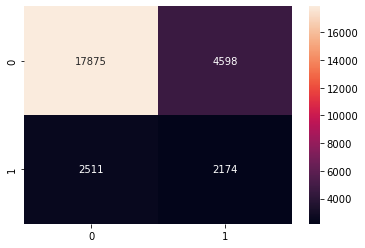

In [40]:
# Visualising the confusion matrix heatmap
sns.heatmap(cf_matrix, annot=True, fmt='g')

In [42]:
print('AUC score of {:.3f}'.format(roc_auc_score(y_test, y_score)))

AUC score of 0.736


In [41]:
feature_imps = [(imp, X.columns[i]) for i, imp in enumerate(clf.feature_importances_)]
feature_imps.sort()
feature_imps.reverse()
print('Random Foresta Feature Importances:')
for i, f in enumerate(feature_imps[0:8]):
    print('{}: {} [{:.3f}]'.format(i + 1, f[1], f[0]/feature_imps[0][0]))

Decision Tree Feature Importances:
1: locations.COUNT(appointments) [1.000]
2: ages.COUNT(appointments) [0.975]
3: Age [0.939]
4: DAY(appointment_day) [0.924]
5: locations.PERCENT_TRUE(appointments.No_show) [0.757]
6: ages.PERCENT_TRUE(appointments.No_show) [0.744]
7: locations.PERCENT_TRUE(appointments.SMS_received) [0.742]
8: ages.PERCENT_TRUE(appointments.SMS_received) [0.738]


In [43]:
from featuretools.selection import (
    remove_highly_correlated_features,
    remove_single_value_features,
)

from featuretools.primitives import NaturalLanguage

In [81]:
new_fm, new_features = remove_highly_correlated_features(fm, features=features, pct_corr_threshold=.9)
new_fm.head()

,Neighbourhood,Gender,patient_id,Age,SMS_received,DAY(appointment_day),DAY(scheduled_time),IS_WEEKEND(appointment_day),IS_WEEKEND(scheduled_time),MONTH(appointment_day),...,genders.COUNT(appointments),patients.PERCENT_TRUE(appointments.IS_WEEKEND(appointment_day)),patients.PERCENT_TRUE(appointments.IS_WEEKEND(scheduled_time)),locations.PERCENT_TRUE(appointments.IS_WEEKEND(appointment_day)),locations.PERCENT_TRUE(appointments.IS_WEEKEND(scheduled_time)),ages.PERCENT_TRUE(appointments.IS_WEEKEND(appointment_day)),ages.PERCENT_TRUE(appointments.IS_WEEKEND(scheduled_time)),genders.PERCENT_TRUE(appointments.IS_WEEKEND(appointment_day)),genders.PERCENT_TRUE(appointments.IS_WEEKEND(scheduled_time)),label
appointment_id,,,,,,,,,,,,,,,,,,,,,
5623805,SANTA MARTHA,F,4.532923e+10,18,True,31,26,False,False,5,...,13105,0.0,0.0,0.0,0.002188,0.0,0.0,0.0,0.000305,False
5623811,SANTA MARTHA,M,7.756472e+12,27,True,5,26,False,False,5,...,6438,0.0,0.0,0.0,0.002188,0.0,0.0,0.0,0.000000,False
5623814,JARDIM CAMBURI,M,7.267524e+12,20,True,11,26,False,False,5,...,6438,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,False
5623815,SANTO ANTÔNIO,F,7.762846e+13,33,False,16,26,False,False,5,...,13105,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000305,False
5623817,REPÚBLICA,F,2.986375e+12,74,True,5,26,False,False,5,...,13105,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000305,False


In [82]:
set(features) - set(new_features)

{<Feature: No_show>,
 <Feature: ages.PERCENT_TRUE(appointments.SMS_received)>,
 <Feature: genders.PERCENT_TRUE(appointments.No_show)>,
 <Feature: genders.PERCENT_TRUE(appointments.SMS_received)>}

In [83]:
new_fm

,Neighbourhood,Gender,patient_id,Age,SMS_received,DAY(appointment_day),DAY(scheduled_time),IS_WEEKEND(appointment_day),IS_WEEKEND(scheduled_time),MONTH(appointment_day),...,genders.COUNT(appointments),patients.PERCENT_TRUE(appointments.IS_WEEKEND(appointment_day)),patients.PERCENT_TRUE(appointments.IS_WEEKEND(scheduled_time)),locations.PERCENT_TRUE(appointments.IS_WEEKEND(appointment_day)),locations.PERCENT_TRUE(appointments.IS_WEEKEND(scheduled_time)),ages.PERCENT_TRUE(appointments.IS_WEEKEND(appointment_day)),ages.PERCENT_TRUE(appointments.IS_WEEKEND(scheduled_time)),genders.PERCENT_TRUE(appointments.IS_WEEKEND(appointment_day)),genders.PERCENT_TRUE(appointments.IS_WEEKEND(scheduled_time)),label
appointment_id,,,,,,,,,,,,,,,,,,,,,
5623805,SANTA MARTHA,F,4.532923e+10,18,True,31,26,False,False,5,...,13105,0.0,0.0,0.0,0.002188,0.000000,0.0,0.000000,0.000305,False
5623811,SANTA MARTHA,M,7.756472e+12,27,True,5,26,False,False,5,...,6438,0.0,0.0,0.0,0.002188,0.000000,0.0,0.000000,0.000000,False
5623814,JARDIM CAMBURI,M,7.267524e+12,20,True,11,26,False,False,5,...,6438,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,False
5623815,SANTO ANTÔNIO,F,7.762846e+13,33,False,16,26,False,False,5,...,13105,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000305,False
5623817,REPÚBLICA,F,2.986375e+12,74,True,5,26,False,False,5,...,13105,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000305,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5790461,JARDIM CAMBURI,M,7.292552e+14,54,False,8,8,False,False,6,...,38679,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000259,0.000181,False
5790464,JARDIM CAMBURI,F,9.476144e+14,43,False,8,8,False,False,6,...,71823,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000404,0.000237,False
5790466,JARDIM CAMBURI,M,3.562479e+11,27,False,8,8,False,False,6,...,38679,0.0,0.0,0.0,0.000000,0.000727,0.0,0.000259,0.000181,False


In [84]:
# Making new_X and new_y dataset
new_X = new_fm.copy()
new_label = new_X.pop('label')
new_X = new_X.drop(['patient_id', 'Neighbourhood', 'Gender'], axis=1)

new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, label, test_size=0.30, random_state=200, stratify = label)

# Due to comparison the target variable has some imbalance as roughly 80% is no and 20% is yes
# Undersampling will be used in an attempt to balance the data
undersample = RandomUnderSampler(random_state=140, sampling_strategy=0.6) # define undersample strategy
new_X_train, new_y_train = undersample.fit_resample(new_X_train, new_y_train)

In [85]:
new_clf=RandomForestClassifier(n_estimators=150, random_state = 240)
new_clf.fit(new_X_train, new_y_train)
new_y_pred = new_clf.predict(new_X_test)

# Obtaining the probability score of the model test
new_y_score = new_clf.predict_proba(new_X_test)[:,1] # Only get the column of "1"
new_cf_matrix = confusion_matrix(new_y_test, new_y_pred)

In [86]:
print(classification_report(new_y_test,new_y_pred))

              precision    recall  f1-score   support

       False       0.88      0.80      0.84     22473
        True       0.33      0.47      0.39      4685

    accuracy                           0.74     27158
   macro avg       0.60      0.64      0.61     27158
weighted avg       0.78      0.74      0.76     27158



<AxesSubplot:>

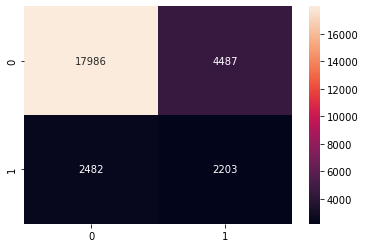

In [87]:
# Visualising the confusion matrix heatmap
sns.heatmap(new_cf_matrix, annot=True, fmt='g')

In [88]:
print('AUC score of {:.3f}'.format(roc_auc_score(new_y_test, new_y_score)))

AUC score of 0.738


In [73]:
feature_imps = [(imp, X.columns[i]) for i, imp in enumerate(new_clf.feature_importances_)]
feature_imps.sort()
feature_imps.reverse()
print('Random Forest Feature Importances:')
for i, f in enumerate(feature_imps[0:8]):
    print('{}: {} [{:.3f}]'.format(i + 1, f[1], f[0]/feature_imps[0][0]))

Random Foresta Feature Importances:
1: locations.PERCENT_TRUE(appointments.SMS_received) [1.000]
2: locations.COUNT(appointments) [0.953]
3: Age [0.911]
4: locations.PERCENT_TRUE(appointments.No_show) [0.798]
5: DAY(appointment_day) [0.677]
6: genders.PERCENT_TRUE(appointments.SMS_received) [0.598]
7: patients.DAY(first_appointments_time) [0.432]
8: WEEKDAY(appointment_day) [0.387]
